# CWRU Bearing Fault Diagnosis with Spectrogram and Scalogram Inputs

This notebook implements a Convolutional Neural Network (CNN) for fault diagnosis of rolling element bearings using the Case Western Reserve University (CWRU) dataset. The methodology is based on Verstraete et al. (2017), which uses time-frequency image representations (spectrograms via STFT and scalograms via Morlet wavelet transform) as inputs to a CNN. The CNN architecture features double convolutional layers before pooling to enhance feature expressivity.

## Overview
- **Dataset**: CWRU Bearing Data (2HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, and fold-wise performance plots

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_2HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [15]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [16]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_2HP'
    file_paths = [
        os.path.join(folder_path, '99.mat'),
        os.path.join(folder_path, '111.mat'),
        os.path.join(folder_path, '124.mat'),
        os.path.join(folder_path, '137.mat'),
        os.path.join(folder_path, '176.mat'),
        os.path.join(folder_path, '191.mat'),
        os.path.join(folder_path, '203.mat'),
        os.path.join(folder_path, '215.mat'),
        os.path.join(folder_path, '228.mat'),
        os.path.join(folder_path, '240.mat')
    ]
    data_keys = [
        'X099_DE_time', 'X111_DE_time', 'X124_DE_time', 'X137_DE_time',
        'X176_DE_time', 'X191_DE_time', 'X203_DE_time', 'X215_DE_time',
        'X228_DE_time', 'X240_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data

## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 96x96 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 96x96 pixels.

In [17]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(32, 32)):

    
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(32,32)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [18]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='spectrogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [19]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [21]:
# Parameters
interval_length = 320
samples_per_block = 1600
image_type = 'spectrogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (32,32)
kSplits = 5
foldername = "CNN2D_results/Scalogram_Spectrogram/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)

# K-fold cross-validation
kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)
    
    k += 1

Shape of Input Data: (15169, 32, 32, 1)


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-12 07:59:48.038126: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 07:59:48.040278: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3678 - loss: 1.6195

2025-06-12 08:00:35.287492: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 08:00:35.287768: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.77833, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 163ms/step - accuracy: 0.3683 - loss: 1.6180 - val_accuracy: 0.7783 - val_loss: 0.5118
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7116 - loss: 0.6614
Epoch 2: val_accuracy improved from 0.77833 to 0.82118, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.7116 - loss: 0.6612 - val_accuracy: 0.8212 - val_loss: 0.3656
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7915 - loss: 0.4591
Epoch 3: val_accuracy improved from 0.82118 to 0.83354, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.7916 - loss: 0.4591 - val_accuracy: 0.8335 - val_loss: 0.3152
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8258 - loss: 0.3783
Epoch 4: val_accuracy did not improve from 0.83354
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.8257 - loss: 0.3783 - val_accuracy: 0.8331 - val_loss: 0.3282
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8371 - loss: 0.3444
Epoch 5: val_accuracy improved from 0.83354 to 0.90894, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.8371 - loss: 0.3443 - val_accuracy: 0.9089 - val_loss: 0.2283
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8914 - loss: 0.2811
Epoch 6: val_accuracy improved from 0.90894 to 0.94808, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.8914 - loss: 0.2811 - val_accuracy: 0.9481 - val_loss: 0.1651
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9270 - loss: 0.2096
Epoch 7: val_accuracy did not improve from 0.94808
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9270 - loss: 0.2097 - val_accuracy: 0.9254 - val_loss: 0.1776
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9309 - loss: 0.1900
Epoch 8: val_accuracy improved from 0.94808 to 0.96621, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9309 - loss: 0.1900 - val_accuracy: 0.9662 - val_loss: 0.1011
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9469 - loss: 0.1524
Epoch 9: val_accuracy did not improve from 0.96621
304/304 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.9469 - loss: 0.1525 - val_accuracy: 0.9526 - val_loss: 0.1239
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9373 - loss: 0.1770
Epoch 10: val_accuracy improved from 0.96621 to 0.96869, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.9373 - loss: 0.1769 - val_accuracy: 0.9687 - val_loss: 0.0870
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9520 - loss: 0.1406
Epoch 11: val_accuracy improved from 0.96869 to 0.97239, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9520 - loss: 0.1406 - val_accuracy: 0.9724 - val_loss: 0.0887
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9646 - loss: 0.1077
Epoch 12: val_accuracy did not improve from 0.97239
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9646 - loss: 0.1077 - val_accuracy: 0.9720 - val_loss: 0.0865
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9596 - loss: 0.1133
Epoch 13: val_accuracy improved from 0.97239 to 0.97404, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9596 - loss: 0.1134 - val_accuracy: 0.9740 - val_loss: 0.0853
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9676 - loss: 0.0971
Epoch 14: val_accuracy improved from 0.97404 to 0.97734, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9676 - loss: 0.0971 - val_accuracy: 0.9773 - val_loss: 0.0751
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9700 - loss: 0.0975
Epoch 15: val_accuracy did not improve from 0.97734
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9700 - loss: 0.0975 - val_accuracy: 0.9753 - val_loss: 0.0759
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9762 - loss: 0.0767
Epoch 16: val_accuracy improved from 0.97734 to 0.97940, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9762 - loss: 0.0767 - val_accuracy: 0.9794 - val_loss: 0.0592
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9705 - loss: 0.0864
Epoch 17: val_accuracy did not improve from 0.97940
304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.9705 - loss: 0.0864 - val_accuracy: 0.9642 - val_loss: 0.1044
Epoch 18/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9709 - loss: 0.0936
Epoch 18: val_accuracy improved from 0.97940 to 0.97981, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.9709 - loss: 0.0936 - val_accuracy: 0.9798 - val_loss: 0.0604
Epoch 19/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9723 - loss: 0.0767
Epoch 19: val_accuracy improved from 0.97981 to 0.98146, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9723 - loss: 0.0767 - val_accuracy: 0.9815 - val_loss: 0.0529
Epoch 20/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9760 - loss: 0.0721
Epoch 20: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9760 - loss: 0.0721 - val_accuracy: 0.9786 - val_loss: 0.0639
Epoch 21/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9775 - loss: 0.0750
Epoch 21: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9775 - loss: 0.0750 - val_accuracy: 0.9810 - val_loss: 0.0548
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9758 - loss: 0.0782
Epoch 22: val_accuracy did not improve from 0.98146
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9757 - loss: 0.0783 - val_accuracy: 0.9769 - val_loss: 0.0655
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9754 - loss: 0.0725
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9830 - loss: 0.0510 - val_accuracy: 0.9827 - val_loss: 0.0526
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9787 - loss: 0.0644
Epoch 26: val_accuracy did not improve from 0.98269
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9787 - loss: 0.0644 - val_accuracy: 0.9790 - val_loss: 0.0771
Epoch 27/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9771 - loss: 0.0671
Epoch 27: val_accuracy did not improve from 0.98269
304/304 ━━━━━━━━━━━━━━━━━━━━ 69s 226ms/step - accuracy: 0.9771 - loss: 0.0671 - val_accuracy: 0.9827 - val_loss: 0.0479
Epoch 28/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9863 - loss: 0.0423
Epoch 28: val_accuracy improved from 0.98269 to 0.98434, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 63s 208ms/step - accuracy: 0.9863 - loss: 0.0423 - val_accuracy: 0.9843 - val_loss: 0.0540
Epoch 29/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9840 - loss: 0.0436
Epoch 29: val_accuracy improved from 0.98434 to 0.98475, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9840 - loss: 0.0437 - val_accuracy: 0.9848 - val_loss: 0.0409
Epoch 30/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9864 - loss: 0.0402
Epoch 30: val_accuracy improved from 0.98475 to 0.98517, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9864 - loss: 0.0402 - val_accuracy: 0.9852 - val_loss: 0.0389
Epoch 31/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9841 - loss: 0.0445
Epoch 31: val_accuracy did not improve from 0.98517
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9841 - loss: 0.0445 - val_accuracy: 0.9786 - val_loss: 0.0648
Epoch 32/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9826 - loss: 0.0513
Epoch 32: val_accuracy improved from 0.98517 to 0.98640, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9826 - loss: 0.0512 - val_accuracy: 0.9864 - val_loss: 0.0363
Epoch 33/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9845 - loss: 0.0438
Epoch 33: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9845 - loss: 0.0438 - val_accuracy: 0.9848 - val_loss: 0.0501
Epoch 34/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9896 - loss: 0.0316
Epoch 34: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9896 - loss: 0.0316 - val_accuracy: 0.9852 - val_loss: 0.0468
Epoch 35/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9815 - loss: 0.0583
Epoch 35: val_accuracy improved from 0.98640 to 0.98805, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9815 - loss: 0.0583 - val_accuracy: 0.9881 - val_loss: 0.0388
Epoch 36/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9898 - loss: 0.0280
Epoch 36: val_accuracy did not improve from 0.98805
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9898 - loss: 0.0280 - val_accuracy: 0.9881 - val_loss: 0.0377
Epoch 37/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9873 - loss: 0.0343
Epoch 37: val_accuracy did not improve from 0.98805
304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - accuracy: 0.9873 - loss: 0.0343 - val_accuracy: 0.9839 - val_loss: 0.0428
Epoch 38/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9873 - loss: 0.0401
Epoch 38: val_accuracy did not improve from 0.98805
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9873 - loss: 0.0401 - val_accuracy: 0.9827 - val_loss: 0.0483
Epoch 39/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9887 - loss: 0.0325
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9893 - loss: 0.0288 - val_accuracy: 0.9885 - val_loss: 0.0358
Epoch 42/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9914 - loss: 0.0217
Epoch 42: val_accuracy improved from 0.98846 to 0.98929, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_1.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9914 - loss: 0.0217 - val_accuracy: 0.9893 - val_loss: 0.0337
Epoch 43/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9934 - loss: 0.0163
Epoch 43: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 191ms/step - accuracy: 0.9934 - loss: 0.0164 - val_accuracy: 0.9868 - val_loss: 0.0441
Epoch 44/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9865 - loss: 0.0422
Epoch 44: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 201ms/step - accuracy: 0.9865 - loss: 0.0422 - val_accuracy: 0.9823 - val_loss: 0.0604
Epoch 45/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9762 - loss: 0.0845
Epoch 45: val_accuracy did not improve from 0.98929
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9762 - loss: 0.0845 - val_accuracy: 0.9819 - val_loss: 0.0504
Epoch 46/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9913 - loss: 0.0278
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9890 - loss: 0.0365 - val_accuracy: 0.9897 - val_loss: 0.0382
Epoch 61/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9982 - loss: 0.0063
Epoch 61: val_accuracy did not improve from 0.98970
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9835 - val_loss: 0.0796
Epoch 62/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9944 - loss: 0.0184
Epoch 62: val_accuracy did not improve from 0.98970
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 184ms/step - accuracy: 0.9944 - loss: 0.0184 - val_accuracy: 0.9864 - val_loss: 0.0353
Epoch 63/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9947 - loss: 0.0183
Epoch 63: val_accuracy did not improve from 0.98970
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9947 - loss: 0.0183 - val_accuracy: 0.9839 - val_loss: 0.0485
Epoch 64/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9977 - loss: 0.0082
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9942 - loss: 0.0251 - val_accuracy: 0.9905 - val_loss: 0.0293
Epoch 98/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9986 - loss: 0.0060
Epoch 98: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9881 - val_loss: 0.0432
Epoch 99/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9977 - loss: 0.0078
Epoch 99: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9977 - loss: 0.0078 - val_accuracy: 0.9881 - val_loss: 0.0410
Epoch 100/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9978 - loss: 0.0075
Epoch 100: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 0.9868 - val_loss: 0.0478
Epoch 101/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9963 - loss: 0.0128
E

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9966 - loss: 0.0235 - val_accuracy: 0.9918 - val_loss: 0.0318
Epoch 116/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9994 - loss: 0.0033
Epoch 116: val_accuracy did not improve from 0.99176
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9881 - val_loss: 0.0410
Epoch 117/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 117: val_accuracy did not improve from 0.99176
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9889 - val_loss: 0.0372
Epoch 118/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9994 - loss: 8.1572e-04
Epoch 118: val_accuracy did not improve from 0.99176
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9994 - loss: 8.1495e-04 - val_accuracy: 0.9918 - val_loss: 0.0392
Epoch 119/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9954 - lo

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 174ms/step - accuracy: 1.0000 - loss: 5.9796e-05 - val_accuracy: 0.9922 - val_loss: 0.0449
Epoch 159/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9982 - loss: 0.0087
Epoch 159: val_accuracy did not improve from 0.99217
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9982 - loss: 0.0087 - val_accuracy: 0.9868 - val_loss: 0.0423
Epoch 160/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9992 - loss: 0.0028
Epoch 160: val_accuracy did not improve from 0.99217
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 183ms/step - accuracy: 0.9992 - loss: 0.0028 - val_accuracy: 0.9881 - val_loss: 0.0401
Epoch 161/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9965 - loss: 0.0154
Epoch 161: val_accuracy did not improve from 0.99217
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9965 - loss: 0.0154 - val_accuracy: 0.9872 - val_loss: 0.0342
Epoch 162/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9959 - loss: 

304/304 ━━━━━━━━━━━━━━━━━━━━ 62s 204ms/step - accuracy: 0.9952 - loss: 0.0460 - val_accuracy: 0.9934 - val_loss: 0.0281
Epoch 187/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9990 - loss: 0.0060
Epoch 187: val_accuracy did not improve from 0.99341
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9990 - loss: 0.0060 - val_accuracy: 0.9897 - val_loss: 0.0290
Epoch 188/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9997 - loss: 8.6706e-04
Epoch 188: val_accuracy did not improve from 0.99341
304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 190ms/step - accuracy: 0.9997 - loss: 8.6873e-04 - val_accuracy: 0.9852 - val_loss: 0.0534
Epoch 189/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9975 - loss: 0.0078
Epoch 189: val_accuracy did not improve from 0.99341
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accuracy: 0.9905 - val_loss: 0.0330
Epoch 190/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9979 - lo

Best model loaded successfully!
 1/76 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step

2025-06-12 10:55:52.378670: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 10:55:52.380917: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 1.0000 - loss: 8.7903e-04
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9809 - loss: 0.1716

2025-06-12 10:56:10.230506: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 10:56:10.230863: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9922 - loss: 0.0398
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9895 - loss: 0.0240
Epoch 1/200


2025-06-12 10:56:18.179111: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 10:56:18.179524: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3514 - loss: 1.6389

2025-06-12 10:57:07.828120: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 10:57:07.830238: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.73836, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 165ms/step - accuracy: 0.3519 - loss: 1.6375 - val_accuracy: 0.7384 - val_loss: 0.6198
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7370 - loss: 0.6165
Epoch 2: val_accuracy improved from 0.73836 to 0.81129, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.7370 - loss: 0.6164 - val_accuracy: 0.8113 - val_loss: 0.4272
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8107 - loss: 0.4480
Epoch 3: val_accuracy improved from 0.81129 to 0.82777, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8107 - loss: 0.4480 - val_accuracy: 0.8278 - val_loss: 0.3595
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8490 - loss: 0.3585
Epoch 4: val_accuracy improved from 0.82777 to 0.90194, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.8490 - loss: 0.3584 - val_accuracy: 0.9019 - val_loss: 0.2504
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8986 - loss: 0.2698
Epoch 5: val_accuracy improved from 0.90194 to 0.91718, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.8986 - loss: 0.2698 - val_accuracy: 0.9172 - val_loss: 0.2001
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9263 - loss: 0.2071
Epoch 6: val_accuracy improved from 0.91718 to 0.94932, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9263 - loss: 0.2072 - val_accuracy: 0.9493 - val_loss: 0.1336
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9413 - loss: 0.1717
Epoch 7: val_accuracy improved from 0.94932 to 0.95797, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9413 - loss: 0.1717 - val_accuracy: 0.9580 - val_loss: 0.1167
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9520 - loss: 0.1372
Epoch 8: val_accuracy improved from 0.95797 to 0.96374, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9520 - loss: 0.1372 - val_accuracy: 0.9637 - val_loss: 0.0914
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9536 - loss: 0.1278
Epoch 9: val_accuracy did not improve from 0.96374
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9536 - loss: 0.1278 - val_accuracy: 0.9625 - val_loss: 0.1032
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9536 - loss: 0.1327
Epoch 10: val_accuracy did not improve from 0.96374
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9536 - loss: 0.1327 - val_accuracy: 0.9543 - val_loss: 0.1156
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9623 - loss: 0.1049
Epoch 11: val_accuracy improved from 0.96374 to 0.96498, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9623 - loss: 0.1050 - val_accuracy: 0.9650 - val_loss: 0.0946
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9678 - loss: 0.1031
Epoch 12: val_accuracy did not improve from 0.96498
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9678 - loss: 0.1031 - val_accuracy: 0.9642 - val_loss: 0.0926
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9683 - loss: 0.0933
Epoch 13: val_accuracy improved from 0.96498 to 0.96910, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9683 - loss: 0.0933 - val_accuracy: 0.9691 - val_loss: 0.0815
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9673 - loss: 0.1017
Epoch 14: val_accuracy did not improve from 0.96910
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9673 - loss: 0.1018 - val_accuracy: 0.9670 - val_loss: 0.0857
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9704 - loss: 0.0884
Epoch 15: val_accuracy did not improve from 0.96910
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9703 - loss: 0.0884 - val_accuracy: 0.9588 - val_loss: 0.1329
Epoch 16/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9683 - loss: 0.0888
Epoch 16: val_accuracy improved from 0.96910 to 0.97569, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9683 - loss: 0.0888 - val_accuracy: 0.9757 - val_loss: 0.0674
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9776 - loss: 0.0645
Epoch 17: val_accuracy did not improve from 0.97569
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9776 - loss: 0.0646 - val_accuracy: 0.9753 - val_loss: 0.0661
Epoch 18/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9777 - loss: 0.0684
Epoch 18: val_accuracy did not improve from 0.97569
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9776 - loss: 0.0685 - val_accuracy: 0.9662 - val_loss: 0.0915
Epoch 19/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9780 - loss: 0.0673
Epoch 19: val_accuracy did not improve from 0.97569
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9780 - loss: 0.0673 - val_accuracy: 0.9757 - val_loss: 0.0603
Epoch 20/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9801 - loss: 0.0536
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9798 - loss: 0.0575 - val_accuracy: 0.9794 - val_loss: 0.0529
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9815 - loss: 0.0506
Epoch 22: val_accuracy did not improve from 0.97940
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9814 - loss: 0.0506 - val_accuracy: 0.9707 - val_loss: 0.1014
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9741 - loss: 0.0814
Epoch 23: val_accuracy improved from 0.97940 to 0.98146, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9741 - loss: 0.0814 - val_accuracy: 0.9815 - val_loss: 0.0517
Epoch 24/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9852 - loss: 0.0453
Epoch 24: val_accuracy improved from 0.98146 to 0.98393, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_2.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9852 - loss: 0.0453 - val_accuracy: 0.9839 - val_loss: 0.0430
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9839 - loss: 0.0511
Epoch 25: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9839 - loss: 0.0511 - val_accuracy: 0.9794 - val_loss: 0.0583
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9837 - loss: 0.0515
Epoch 26: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9837 - loss: 0.0515 - val_accuracy: 0.9761 - val_loss: 0.0663
Epoch 27/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9778 - loss: 0.0744
Epoch 27: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9778 - loss: 0.0744 - val_accuracy: 0.9827 - val_loss: 0.0438
Epoch 28/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9872 - loss: 0.0426
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9886 - loss: 0.0336 - val_accuracy: 0.9843 - val_loss: 0.0474
Epoch 38/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9910 - loss: 0.0273
Epoch 38: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9910 - loss: 0.0274 - val_accuracy: 0.9650 - val_loss: 0.0891
Epoch 39/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9849 - loss: 0.0491
Epoch 39: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9849 - loss: 0.0492 - val_accuracy: 0.9819 - val_loss: 0.0530
Epoch 40/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9903 - loss: 0.0307
Epoch 40: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9903 - loss: 0.0307 - val_accuracy: 0.9843 - val_loss: 0.0519
Epoch 41/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9909 - loss: 0.0292
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9938 - loss: 0.0209 - val_accuracy: 0.9860 - val_loss: 0.0451
Epoch 47/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9919 - loss: 0.0257
Epoch 47: val_accuracy did not improve from 0.98599
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9919 - loss: 0.0257 - val_accuracy: 0.9679 - val_loss: 0.1156
Epoch 48/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9851 - loss: 0.0679
Epoch 48: val_accuracy did not improve from 0.98599
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9852 - loss: 0.0678 - val_accuracy: 0.9819 - val_loss: 0.0678
Epoch 49/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9971 - loss: 0.0135
Epoch 49: val_accuracy did not improve from 0.98599
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9971 - loss: 0.0135 - val_accuracy: 0.9802 - val_loss: 0.0695
Epoch 50/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9960 - loss: 0.0136
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 160ms/step - accuracy: 0.9932 - loss: 0.0222 - val_accuracy: 0.9868 - val_loss: 0.0568
Epoch 55/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9949 - loss: 0.0184
Epoch 55: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 157ms/step - accuracy: 0.9948 - loss: 0.0184 - val_accuracy: 0.9749 - val_loss: 0.1005
Epoch 56/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9926 - loss: 0.0233
Epoch 56: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9926 - loss: 0.0233 - val_accuracy: 0.9609 - val_loss: 0.1718
Epoch 57/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9952 - loss: 0.0148
Epoch 57: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9952 - loss: 0.0147 - val_accuracy: 0.9839 - val_loss: 0.0739
Epoch 58/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9967 - loss: 0.0135
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.9979 - loss: 0.0085 - val_accuracy: 0.9889 - val_loss: 0.0636
Epoch 66/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9983 - loss: 0.0061
Epoch 66: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 0.9860 - val_loss: 0.0772
Epoch 67/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9948 - loss: 0.0167
Epoch 67: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9948 - loss: 0.0167 - val_accuracy: 0.9835 - val_loss: 0.0840
Epoch 68/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9963 - loss: 0.0143
Epoch 68: val_accuracy did not improve from 0.98888
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 179ms/step - accuracy: 0.9963 - loss: 0.0143 - val_accuracy: 0.9765 - val_loss: 0.0871
Epoch 69/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9850 - loss: 0.0616
Epoc

Best model loaded successfully!
 2/76 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step  

2025-06-12 12:35:12.096855: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 12:35:12.100401: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.9977 - loss: 0.0071
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0060

2025-06-12 12:35:32.120041: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 12:35:32.121563: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9907 - loss: 0.0545
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.9891 - loss: 0.0370
Epoch 1/200


2025-06-12 12:35:41.045891: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 12:35:41.046257: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3786 - loss: 1.5844

2025-06-12 12:36:32.170448: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 12:36:32.170796: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.80635, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 177ms/step - accuracy: 0.3792 - loss: 1.5828 - val_accuracy: 0.8063 - val_loss: 0.4545
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.7700 - loss: 0.5497
Epoch 2: val_accuracy did not improve from 0.80635
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 180ms/step - accuracy: 0.7700 - loss: 0.5495 - val_accuracy: 0.7796 - val_loss: 0.4456
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8031 - loss: 0.4472
Epoch 3: val_accuracy improved from 0.80635 to 0.84054, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - accuracy: 0.8031 - loss: 0.4471 - val_accuracy: 0.8405 - val_loss: 0.3199
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8218 - loss: 0.3802
Epoch 4: val_accuracy did not improve from 0.84054
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8218 - loss: 0.3801 - val_accuracy: 0.8191 - val_loss: 0.3441
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8521 - loss: 0.3168
Epoch 5: val_accuracy improved from 0.84054 to 0.91512, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.8521 - loss: 0.3167 - val_accuracy: 0.9151 - val_loss: 0.1921
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9041 - loss: 0.2603
Epoch 6: val_accuracy improved from 0.91512 to 0.94602, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 63s 206ms/step - accuracy: 0.9041 - loss: 0.2602 - val_accuracy: 0.9460 - val_loss: 0.1614
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9354 - loss: 0.1797
Epoch 7: val_accuracy did not improve from 0.94602
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9354 - loss: 0.1797 - val_accuracy: 0.9312 - val_loss: 0.1556
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9358 - loss: 0.1749
Epoch 8: val_accuracy improved from 0.94602 to 0.96910, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9359 - loss: 0.1748 - val_accuracy: 0.9691 - val_loss: 0.0961
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9473 - loss: 0.1611
Epoch 9: val_accuracy did not improve from 0.96910
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9473 - loss: 0.1611 - val_accuracy: 0.9530 - val_loss: 0.1089
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9547 - loss: 0.1341
Epoch 10: val_accuracy improved from 0.96910 to 0.97281, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9547 - loss: 0.1341 - val_accuracy: 0.9728 - val_loss: 0.0789
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9595 - loss: 0.1173
Epoch 11: val_accuracy improved from 0.97281 to 0.97899, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9595 - loss: 0.1173 - val_accuracy: 0.9790 - val_loss: 0.0665
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9641 - loss: 0.1010
Epoch 12: val_accuracy did not improve from 0.97899
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9641 - loss: 0.1010 - val_accuracy: 0.9724 - val_loss: 0.0773
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9660 - loss: 0.0952
Epoch 13: val_accuracy did not improve from 0.97899
304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - accuracy: 0.9660 - loss: 0.0952 - val_accuracy: 0.9699 - val_loss: 0.0730
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9647 - loss: 0.1045
Epoch 14: val_accuracy did not improve from 0.97899
304/304 ━━━━━━━━━━━━━━━━━━━━ 58s 191ms/step - accuracy: 0.9647 - loss: 0.1045 - val_accuracy: 0.9679 - val_loss: 0.0801
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9501 - loss: 0.1471
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9823 - loss: 0.0573 - val_accuracy: 0.9794 - val_loss: 0.0569
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9842 - loss: 0.0481
Epoch 22: val_accuracy did not improve from 0.97940
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9842 - loss: 0.0482 - val_accuracy: 0.9740 - val_loss: 0.0724
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9817 - loss: 0.0583
Epoch 23: val_accuracy did not improve from 0.97940
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9817 - loss: 0.0585 - val_accuracy: 0.9720 - val_loss: 0.0762
Epoch 24/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9837 - loss: 0.0524
Epoch 24: val_accuracy did not improve from 0.97940
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9837 - loss: 0.0524 - val_accuracy: 0.9794 - val_loss: 0.0574
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9771 - loss: 0.0703
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9864 - loss: 0.0383 - val_accuracy: 0.9802 - val_loss: 0.0586
Epoch 28/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9806 - loss: 0.0616
Epoch 28: val_accuracy did not improve from 0.98022
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9806 - loss: 0.0616 - val_accuracy: 0.9782 - val_loss: 0.0578
Epoch 29/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9871 - loss: 0.0385
Epoch 29: val_accuracy did not improve from 0.98022
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9871 - loss: 0.0386 - val_accuracy: 0.9736 - val_loss: 0.0705
Epoch 30/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9859 - loss: 0.0511
Epoch 30: val_accuracy did not improve from 0.98022
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9859 - loss: 0.0511 - val_accuracy: 0.9782 - val_loss: 0.0677
Epoch 31/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9861 - loss: 0.0469
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9861 - loss: 0.0469 - val_accuracy: 0.9823 - val_loss: 0.0588
Epoch 32/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9873 - loss: 0.0409
Epoch 32: val_accuracy did not improve from 0.98228
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9873 - loss: 0.0410 - val_accuracy: 0.9650 - val_loss: 0.0800
Epoch 33/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9849 - loss: 0.0464
Epoch 33: val_accuracy did not improve from 0.98228
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9849 - loss: 0.0464 - val_accuracy: 0.9794 - val_loss: 0.0513
Epoch 34/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9911 - loss: 0.0312
Epoch 34: val_accuracy improved from 0.98228 to 0.98352, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9911 - loss: 0.0313 - val_accuracy: 0.9835 - val_loss: 0.0433
Epoch 35/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9914 - loss: 0.0271
Epoch 35: val_accuracy did not improve from 0.98352
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9914 - loss: 0.0271 - val_accuracy: 0.9526 - val_loss: 0.2455
Epoch 36/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9783 - loss: 0.0802
Epoch 36: val_accuracy did not improve from 0.98352
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9783 - loss: 0.0802 - val_accuracy: 0.9761 - val_loss: 0.0675
Epoch 37/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9819 - loss: 0.0611
Epoch 37: val_accuracy did not improve from 0.98352
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9819 - loss: 0.0611 - val_accuracy: 0.9815 - val_loss: 0.0494
Epoch 38/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9891 - loss: 0.0299
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9891 - loss: 0.0300 - val_accuracy: 0.9839 - val_loss: 0.0502
Epoch 39/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9923 - loss: 0.0262
Epoch 39: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9923 - loss: 0.0262 - val_accuracy: 0.9778 - val_loss: 0.0655
Epoch 40/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9932 - loss: 0.0235
Epoch 40: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9932 - loss: 0.0235 - val_accuracy: 0.9679 - val_loss: 0.1010
Epoch 41/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9874 - loss: 0.0409
Epoch 41: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9874 - loss: 0.0409 - val_accuracy: 0.9724 - val_loss: 0.0817
Epoch 42/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9924 - loss: 0.0225
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.9928 - loss: 0.0175 - val_accuracy: 0.9843 - val_loss: 0.0510
Epoch 48/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9910 - loss: 0.0257
Epoch 48: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 183ms/step - accuracy: 0.9910 - loss: 0.0258 - val_accuracy: 0.9032 - val_loss: 0.6694
Epoch 49/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9846 - loss: 0.0624
Epoch 49: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.9846 - loss: 0.0623 - val_accuracy: 0.9810 - val_loss: 0.0580
Epoch 50/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9941 - loss: 0.0206
Epoch 50: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.9941 - loss: 0.0206 - val_accuracy: 0.9810 - val_loss: 0.0579
Epoch 51/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9911 - loss: 0.0266
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9922 - loss: 0.0260 - val_accuracy: 0.9848 - val_loss: 0.0514
Epoch 59/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9966 - loss: 0.0123
Epoch 59: val_accuracy did not improve from 0.98475
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9966 - loss: 0.0123 - val_accuracy: 0.9815 - val_loss: 0.0572
Epoch 60/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9850 - loss: 0.0767
Epoch 60: val_accuracy did not improve from 0.98475
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 163ms/step - accuracy: 0.9850 - loss: 0.0766 - val_accuracy: 0.9831 - val_loss: 0.0562
Epoch 61/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9938 - loss: 0.0188
Epoch 61: val_accuracy did not improve from 0.98475
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9938 - loss: 0.0188 - val_accuracy: 0.9786 - val_loss: 0.0611
Epoch 62/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9926 - loss: 0.0276
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9976 - loss: 0.0163 - val_accuracy: 0.9864 - val_loss: 0.0719
Epoch 88/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9981 - loss: 0.0067
Epoch 88: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9981 - loss: 0.0067 - val_accuracy: 0.9852 - val_loss: 0.0592
Epoch 89/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9989 - loss: 0.0032
Epoch 89: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 0.9839 - val_loss: 0.0644
Epoch 90/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9994 - loss: 0.0024
Epoch 90: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9794 - val_loss: 0.0681
Epoch 91/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9974 - loss: 0.0075
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9985 - loss: 0.0077 - val_accuracy: 0.9868 - val_loss: 0.0629
Epoch 105/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9997 - loss: 0.0010
Epoch 105: val_accuracy improved from 0.98681 to 0.98764, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_3.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.9876 - val_loss: 0.0718
Epoch 106/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9972 - loss: 0.0106
Epoch 106: val_accuracy did not improve from 0.98764
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9972 - loss: 0.0107 - val_accuracy: 0.9852 - val_loss: 0.0605
Epoch 107/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9896 - loss: 0.0431
Epoch 107: val_accuracy did not improve from 0.98764
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - accuracy: 0.9896 - loss: 0.0432 - val_accuracy: 0.9794 - val_loss: 0.0705
Epoch 108/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9939 - loss: 0.0217
Epoch 108: val_accuracy did not improve from 0.98764
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 177ms/step - accuracy: 0.9939 - loss: 0.0217 - val_accuracy: 0.9835 - val_loss: 0.0527
Epoch 109/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9960 - loss: 0.01

304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9885 - val_loss: 0.0412
Epoch 110/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 110: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 54s 178ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9872 - val_loss: 0.0690
Epoch 111/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9997 - loss: 0.0016
Epoch 111: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.9815 - val_loss: 0.0996
Epoch 112/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9959 - loss: 0.0133
Epoch 112: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9839 - val_loss: 0.0601
Epoch 113/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9940 - loss: 0.03

Best model loaded successfully!
 1/76 ━━━━━━━━━━━━━━━━━━━━ 12s 171ms/step

2025-06-12 14:55:24.301630: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 14:55:24.304303: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.9997 - loss: 0.0059
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9809 - loss: 0.0191

2025-06-12 14:55:42.410011: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 14:55:42.410357: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9879 - loss: 0.0443
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.9852 - loss: 0.0576
Epoch 1/200


2025-06-12 14:55:50.775873: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 14:55:50.776279: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3369 - loss: 1.6785

2025-06-12 14:56:38.193616: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 14:56:38.194017: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.72600, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 165ms/step - accuracy: 0.3373 - loss: 1.6772 - val_accuracy: 0.7260 - val_loss: 0.7166
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.7059 - loss: 0.6702
Epoch 2: val_accuracy improved from 0.72600 to 0.77668, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 57s 188ms/step - accuracy: 0.7060 - loss: 0.6700 - val_accuracy: 0.7767 - val_loss: 0.4844
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7875 - loss: 0.4670
Epoch 3: val_accuracy improved from 0.77668 to 0.84796, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.7875 - loss: 0.4670 - val_accuracy: 0.8480 - val_loss: 0.3135
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8224 - loss: 0.3708
Epoch 4: val_accuracy improved from 0.84796 to 0.87145, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.8224 - loss: 0.3708 - val_accuracy: 0.8714 - val_loss: 0.2858
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8370 - loss: 0.3216
Epoch 5: val_accuracy did not improve from 0.87145
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8370 - loss: 0.3216 - val_accuracy: 0.8681 - val_loss: 0.3002
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8503 - loss: 0.3049
Epoch 6: val_accuracy improved from 0.87145 to 0.88999, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.8503 - loss: 0.3049 - val_accuracy: 0.8900 - val_loss: 0.2169
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8891 - loss: 0.2350
Epoch 7: val_accuracy improved from 0.88999 to 0.95921, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.8891 - loss: 0.2350 - val_accuracy: 0.9592 - val_loss: 0.1188
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9295 - loss: 0.1844
Epoch 8: val_accuracy did not improve from 0.95921
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9295 - loss: 0.1844 - val_accuracy: 0.9571 - val_loss: 0.1229
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9484 - loss: 0.1562
Epoch 9: val_accuracy did not improve from 0.95921
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9484 - loss: 0.1562 - val_accuracy: 0.9333 - val_loss: 0.1862
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9457 - loss: 0.1571
Epoch 10: val_accuracy improved from 0.95921 to 0.96374, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9457 - loss: 0.1571 - val_accuracy: 0.9637 - val_loss: 0.1062
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9549 - loss: 0.1216
Epoch 11: val_accuracy improved from 0.96374 to 0.96786, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9549 - loss: 0.1217 - val_accuracy: 0.9679 - val_loss: 0.0894
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9595 - loss: 0.1172
Epoch 12: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9595 - loss: 0.1172 - val_accuracy: 0.9394 - val_loss: 0.1582
Epoch 13/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9517 - loss: 0.1447
Epoch 13: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9517 - loss: 0.1447 - val_accuracy: 0.9567 - val_loss: 0.1255
Epoch 14/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9648 - loss: 0.0980
Epoch 14: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9648 - loss: 0.0980 - val_accuracy: 0.9604 - val_loss: 0.1026
Epoch 15/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9644 - loss: 0.1089
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9673 - loss: 0.1022 - val_accuracy: 0.9798 - val_loss: 0.0623
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9748 - loss: 0.0834
Epoch 17: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9748 - loss: 0.0835 - val_accuracy: 0.9592 - val_loss: 0.1231
Epoch 18/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9635 - loss: 0.1092
Epoch 18: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9635 - loss: 0.1092 - val_accuracy: 0.9361 - val_loss: 0.1719
Epoch 19/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9712 - loss: 0.0852
Epoch 19: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9712 - loss: 0.0852 - val_accuracy: 0.9679 - val_loss: 0.0926
Epoch 20/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9736 - loss: 0.0883
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9803 - loss: 0.0609 - val_accuracy: 0.9831 - val_loss: 0.0470
Epoch 23/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9796 - loss: 0.0595
Epoch 23: val_accuracy did not improve from 0.98311
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.9795 - loss: 0.0596 - val_accuracy: 0.9757 - val_loss: 0.0922
Epoch 24/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9748 - loss: 0.0724
Epoch 24: val_accuracy did not improve from 0.98311
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 176ms/step - accuracy: 0.9748 - loss: 0.0724 - val_accuracy: 0.9555 - val_loss: 0.1181
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9752 - loss: 0.0704
Epoch 25: val_accuracy did not improve from 0.98311
304/304 ━━━━━━━━━━━━━━━━━━━━ 60s 197ms/step - accuracy: 0.9752 - loss: 0.0704 - val_accuracy: 0.9691 - val_loss: 0.0819
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9787 - loss: 0.0668
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 172ms/step - accuracy: 0.9787 - loss: 0.0668 - val_accuracy: 0.9864 - val_loss: 0.0458
Epoch 27/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9820 - loss: 0.0529
Epoch 27: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9820 - loss: 0.0530 - val_accuracy: 0.9864 - val_loss: 0.0518
Epoch 28/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9806 - loss: 0.0614
Epoch 28: val_accuracy did not improve from 0.98640
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9806 - loss: 0.0614 - val_accuracy: 0.9831 - val_loss: 0.0509
Epoch 29/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9840 - loss: 0.0480
Epoch 29: val_accuracy improved from 0.98640 to 0.99094, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9840 - loss: 0.0481 - val_accuracy: 0.9909 - val_loss: 0.0434
Epoch 30/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9828 - loss: 0.0520
Epoch 30: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9828 - loss: 0.0521 - val_accuracy: 0.9823 - val_loss: 0.0684
Epoch 31/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9845 - loss: 0.0540
Epoch 31: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.9845 - loss: 0.0540 - val_accuracy: 0.9885 - val_loss: 0.0437
Epoch 32/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9587 - loss: 0.1674
Epoch 32: val_accuracy did not improve from 0.99094
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9588 - loss: 0.1672 - val_accuracy: 0.9782 - val_loss: 0.0722
Epoch 33/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9830 - loss: 0.0539
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 181ms/step - accuracy: 0.9949 - loss: 0.0135 - val_accuracy: 0.9922 - val_loss: 0.0301
Epoch 68/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9969 - loss: 0.0076
Epoch 68: val_accuracy improved from 0.99217 to 0.99258, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_4.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 55s 179ms/step - accuracy: 0.9969 - loss: 0.0076 - val_accuracy: 0.9926 - val_loss: 0.0308
Epoch 69/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.9981 - loss: 0.0063
Epoch 69: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 183ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9839 - val_loss: 0.0471
Epoch 70/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9954 - loss: 0.0173
Epoch 70: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9954 - loss: 0.0173 - val_accuracy: 0.9691 - val_loss: 0.1217
Epoch 71/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9936 - loss: 0.0222
Epoch 71: val_accuracy did not improve from 0.99258
304/304 ━━━━━━━━━━━━━━━━━━━━ 59s 195ms/step - accuracy: 0.9936 - loss: 0.0221 - val_accuracy: 0.9881 - val_loss: 0.0444
Epoch 72/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9962 - loss: 0.0141
Epoc

Best model loaded successfully!
 1/76 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step

2025-06-12 16:40:34.820819: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 16:40:34.822481: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - accuracy: 0.9987 - loss: 0.0051
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 1.0000 - loss: 0.0033    

2025-06-12 16:40:53.206636: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 16:40:53.206949: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9956 - loss: 0.0206
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9870 - loss: 0.0305
Epoch 1/200


2025-06-12 16:41:01.485252: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 16:41:01.485641: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2970 - loss: 1.7690

2025-06-12 16:41:54.254207: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 16:41:54.254769: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.69386, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.2975 - loss: 1.7675 - val_accuracy: 0.6939 - val_loss: 0.6723
Epoch 2/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7060 - loss: 0.6853
Epoch 2: val_accuracy improved from 0.69386 to 0.81005, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 169ms/step - accuracy: 0.7061 - loss: 0.6851 - val_accuracy: 0.8101 - val_loss: 0.3809
Epoch 3/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8054 - loss: 0.4595
Epoch 3: val_accuracy improved from 0.81005 to 0.89658, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.8054 - loss: 0.4594 - val_accuracy: 0.8966 - val_loss: 0.2423
Epoch 4/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8639 - loss: 0.3417
Epoch 4: val_accuracy improved from 0.89658 to 0.93037, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.8640 - loss: 0.3416 - val_accuracy: 0.9304 - val_loss: 0.1941
Epoch 5/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9098 - loss: 0.2507
Epoch 5: val_accuracy did not improve from 0.93037
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9099 - loss: 0.2507 - val_accuracy: 0.9287 - val_loss: 0.1767
Epoch 6/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9231 - loss: 0.2117
Epoch 6: val_accuracy improved from 0.93037 to 0.95674, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9231 - loss: 0.2117 - val_accuracy: 0.9567 - val_loss: 0.1257
Epoch 7/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9397 - loss: 0.1702
Epoch 7: val_accuracy improved from 0.95674 to 0.96457, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9397 - loss: 0.1702 - val_accuracy: 0.9646 - val_loss: 0.0976
Epoch 8/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9453 - loss: 0.1463
Epoch 8: val_accuracy improved from 0.96457 to 0.96786, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9453 - loss: 0.1463 - val_accuracy: 0.9679 - val_loss: 0.0933
Epoch 9/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9506 - loss: 0.1462
Epoch 9: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9506 - loss: 0.1461 - val_accuracy: 0.9246 - val_loss: 0.2112
Epoch 10/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9479 - loss: 0.1543
Epoch 10: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9479 - loss: 0.1543 - val_accuracy: 0.9300 - val_loss: 0.1978
Epoch 11/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9532 - loss: 0.1380
Epoch 11: val_accuracy did not improve from 0.96786
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 163ms/step - accuracy: 0.9532 - loss: 0.1379 - val_accuracy: 0.9609 - val_loss: 0.1199
Epoch 12/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9659 - loss: 0.0975
Epoch 

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9584 - loss: 0.1203 - val_accuracy: 0.9712 - val_loss: 0.0702
Epoch 17/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9719 - loss: 0.0839
Epoch 17: val_accuracy improved from 0.97116 to 0.97198, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 161ms/step - accuracy: 0.9719 - loss: 0.0839 - val_accuracy: 0.9720 - val_loss: 0.0750
Epoch 18/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9752 - loss: 0.0689
Epoch 18: val_accuracy improved from 0.97198 to 0.97693, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 166ms/step - accuracy: 0.9752 - loss: 0.0689 - val_accuracy: 0.9769 - val_loss: 0.0770
Epoch 19/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9808 - loss: 0.0520
Epoch 19: val_accuracy did not improve from 0.97693
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9808 - loss: 0.0520 - val_accuracy: 0.9699 - val_loss: 0.0954
Epoch 20/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9680 - loss: 0.1098
Epoch 20: val_accuracy did not improve from 0.97693
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 173ms/step - accuracy: 0.9680 - loss: 0.1098 - val_accuracy: 0.9736 - val_loss: 0.0727
Epoch 21/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9759 - loss: 0.0733
Epoch 21: val_accuracy did not improve from 0.97693
304/304 ━━━━━━━━━━━━━━━━━━━━ 53s 175ms/step - accuracy: 0.9759 - loss: 0.0733 - val_accuracy: 0.9724 - val_loss: 0.0684
Epoch 22/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9760 - loss: 0.0751
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9785 - loss: 0.0662 - val_accuracy: 0.9773 - val_loss: 0.0678
Epoch 25/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9797 - loss: 0.0623
Epoch 25: val_accuracy did not improve from 0.97734
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9797 - loss: 0.0623 - val_accuracy: 0.9732 - val_loss: 0.0691
Epoch 26/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9843 - loss: 0.0505
Epoch 26: val_accuracy did not improve from 0.97734
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 160ms/step - accuracy: 0.9843 - loss: 0.0505 - val_accuracy: 0.9670 - val_loss: 0.1395
Epoch 27/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9697 - loss: 0.0985
Epoch 27: val_accuracy improved from 0.97734 to 0.97981, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 167ms/step - accuracy: 0.9697 - loss: 0.0985 - val_accuracy: 0.9798 - val_loss: 0.0573
Epoch 28/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9839 - loss: 0.0496
Epoch 28: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.9839 - loss: 0.0496 - val_accuracy: 0.9794 - val_loss: 0.0591
Epoch 29/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9839 - loss: 0.0466
Epoch 29: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 171ms/step - accuracy: 0.9839 - loss: 0.0466 - val_accuracy: 0.9654 - val_loss: 0.1222
Epoch 30/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9844 - loss: 0.0466
Epoch 30: val_accuracy did not improve from 0.97981
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9844 - loss: 0.0466 - val_accuracy: 0.9637 - val_loss: 0.1242
Epoch 31/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9857 - loss: 0.0481
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 165ms/step - accuracy: 0.9853 - loss: 0.0407 - val_accuracy: 0.9819 - val_loss: 0.0584
Epoch 33/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9828 - loss: 0.0553
Epoch 33: val_accuracy did not improve from 0.98187
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9828 - loss: 0.0553 - val_accuracy: 0.9778 - val_loss: 0.0587
Epoch 34/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9873 - loss: 0.0382
Epoch 34: val_accuracy did not improve from 0.98187
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.9873 - loss: 0.0382 - val_accuracy: 0.9790 - val_loss: 0.0629
Epoch 35/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9820 - loss: 0.0560
Epoch 35: val_accuracy did not improve from 0.98187
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9820 - loss: 0.0560 - val_accuracy: 0.9778 - val_loss: 0.0665
Epoch 36/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9845 - loss: 0.0466
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9888 - loss: 0.0352 - val_accuracy: 0.9839 - val_loss: 0.0533
Epoch 41/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9917 - loss: 0.0277
Epoch 41: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9917 - loss: 0.0277 - val_accuracy: 0.9786 - val_loss: 0.0548
Epoch 42/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9879 - loss: 0.0311
Epoch 42: val_accuracy did not improve from 0.98393
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.9879 - loss: 0.0311 - val_accuracy: 0.9819 - val_loss: 0.0458
Epoch 43/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9889 - loss: 0.0350
Epoch 43: val_accuracy improved from 0.98393 to 0.98434, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9889 - loss: 0.0350 - val_accuracy: 0.9843 - val_loss: 0.0437
Epoch 44/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9884 - loss: 0.0377
Epoch 44: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 151ms/step - accuracy: 0.9884 - loss: 0.0377 - val_accuracy: 0.9843 - val_loss: 0.0455
Epoch 45/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9900 - loss: 0.0317
Epoch 45: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9900 - loss: 0.0318 - val_accuracy: 0.9732 - val_loss: 0.0681
Epoch 46/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9894 - loss: 0.0324
Epoch 46: val_accuracy did not improve from 0.98434
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9894 - loss: 0.0324 - val_accuracy: 0.9839 - val_loss: 0.0594
Epoch 47/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9940 - loss: 0.0176
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9889 - loss: 0.0413 - val_accuracy: 0.9860 - val_loss: 0.0687
Epoch 49/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9894 - loss: 0.0354
Epoch 49: val_accuracy improved from 0.98599 to 0.98681, saving model to CNN2D_results/Scalogram_Spectrogram/best_model_5.h5


304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9894 - loss: 0.0353 - val_accuracy: 0.9868 - val_loss: 0.0539
Epoch 50/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9888 - loss: 0.0377
Epoch 50: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 164ms/step - accuracy: 0.9888 - loss: 0.0378 - val_accuracy: 0.9749 - val_loss: 0.0988
Epoch 51/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9860 - loss: 0.0415
Epoch 51: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 50s 166ms/step - accuracy: 0.9860 - loss: 0.0415 - val_accuracy: 0.9868 - val_loss: 0.0587
Epoch 52/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9936 - loss: 0.0184
Epoch 52: val_accuracy did not improve from 0.98681
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9936 - loss: 0.0184 - val_accuracy: 0.9815 - val_loss: 0.0597
Epoch 53/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9908 - loss: 0.0250
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 155ms/step - accuracy: 0.9930 - loss: 0.0242 - val_accuracy: 0.9885 - val_loss: 0.0518
Epoch 64/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9962 - loss: 0.0137
Epoch 64: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9962 - loss: 0.0137 - val_accuracy: 0.9831 - val_loss: 0.0734
Epoch 65/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9971 - loss: 0.0132
Epoch 65: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 152ms/step - accuracy: 0.9970 - loss: 0.0132 - val_accuracy: 0.9848 - val_loss: 0.0519
Epoch 66/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9821 - loss: 0.0829
Epoch 66: val_accuracy did not improve from 0.98846
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9821 - loss: 0.0827 - val_accuracy: 0.9819 - val_loss: 0.0520
Epoch 67/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9951 - loss: 0.0209
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 49s 159ms/step - accuracy: 0.9973 - loss: 0.0137 - val_accuracy: 0.9901 - val_loss: 0.0460
Epoch 93/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9993 - loss: 0.0045
Epoch 93: val_accuracy did not improve from 0.99011
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9992 - loss: 0.0045 - val_accuracy: 0.9831 - val_loss: 0.0525
Epoch 94/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9958 - loss: 0.0179
Epoch 94: val_accuracy did not improve from 0.99011
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9958 - loss: 0.0179 - val_accuracy: 0.9852 - val_loss: 0.0552
Epoch 95/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9992 - loss: 0.0056
Epoch 95: val_accuracy did not improve from 0.99011
304/304 ━━━━━━━━━━━━━━━━━━━━ 46s 153ms/step - accuracy: 0.9992 - loss: 0.0057 - val_accuracy: 0.9691 - val_loss: 0.1318
Epoch 96/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9879 - loss: 0.0426
Epoc

304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 170ms/step - accuracy: 0.9983 - loss: 0.0060 - val_accuracy: 0.9905 - val_loss: 0.0391
Epoch 141/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9995 - loss: 0.0018
Epoch 141: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 51s 168ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9885 - val_loss: 0.0580
Epoch 142/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9952 - loss: 0.0242
Epoch 142: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9952 - loss: 0.0243 - val_accuracy: 0.9856 - val_loss: 0.0580
Epoch 143/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9978 - loss: 0.0072
Epoch 143: val_accuracy did not improve from 0.99052
304/304 ━━━━━━━━━━━━━━━━━━━━ 47s 153ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9881 - val_loss: 0.0412
Epoch 144/200
304/304 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9982 - loss: 0.00

Best model loaded successfully!
 1/76 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step

2025-06-12 19:15:07.274533: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 19:15:07.275551: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9994 - loss: 0.0019
 3/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9965 - loss: 0.0124    

2025-06-12 19:15:25.395518: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-12 19:15:25.395829: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9896 - loss: 0.0369
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9860 - loss: 0.0422


## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 99.8990523815155
CNN 2D validation accuracy = 99.07704949378967
CNN 2D test accuracy = 99.02438998222351
  3/380 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step

2025-06-12 19:15:34.035953: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 19:15:34.036268: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step


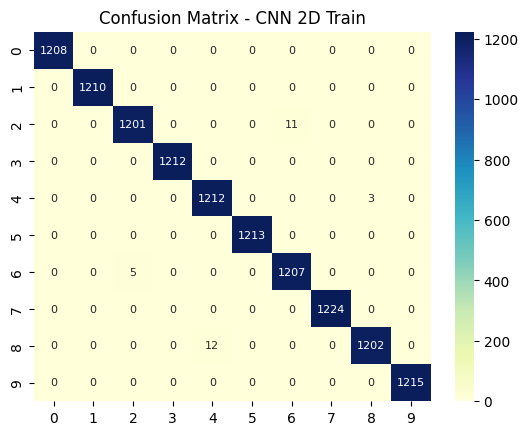

 3/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step

2025-06-12 19:15:50.864626: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-12 19:15:50.865007: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step


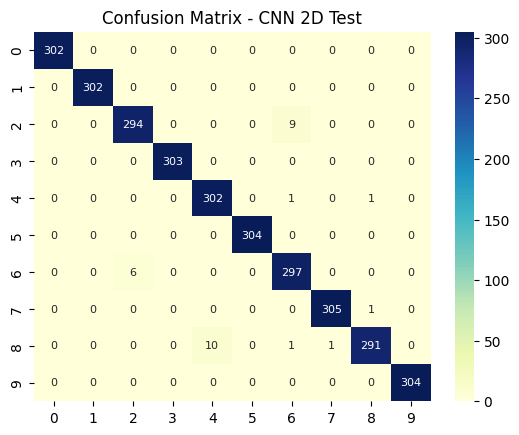

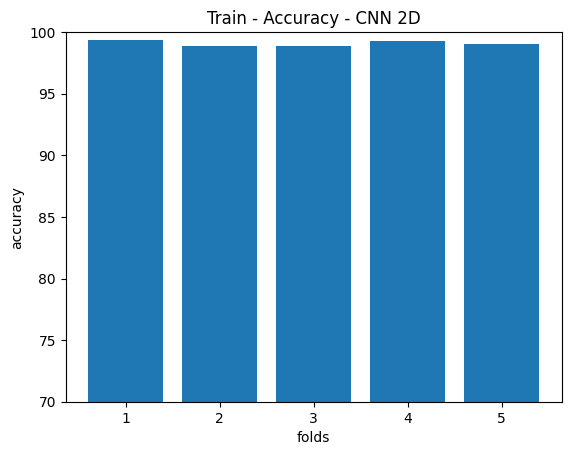

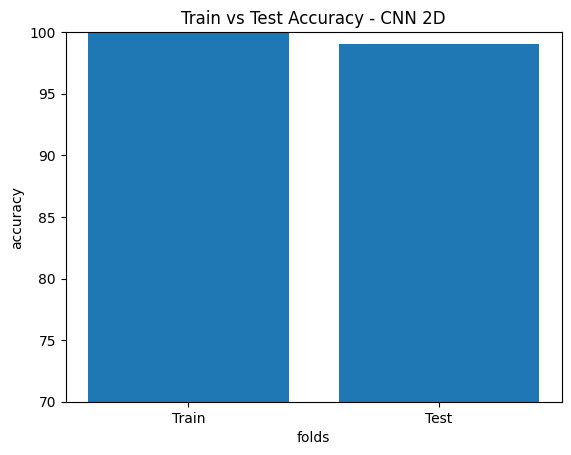

In [22]:
CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()

## Notes

- **Running the Notebook**: Ensure the CWRU dataset files are in the 'CWRU_BearingData_Load_2HP' folder. Install required libraries (e.g., `pip install PyWavelets` for pywt).
- **Switching Input Types**: Change `image_type` to 'spectrogram' in the main execution cell to use spectrograms instead of scalograms.
- **Performance**: Per Verstraete et al., scalograms achieve up to 99.5% accuracy on CWRU data with 96x96 images, outperforming spectrograms (99.5%) and HHT (97.6%).
- **Scalability**: 96x96 images increase computational load. For lower memory usage, set `image_shape = (32, 32)`, but expect reduced accuracy (e.g., 98.8% for scalograms).

This notebook provides an interactive environment to experiment with time-frequency-based fault diagnosis, leveraging the strengths of CNNs for automatic feature learning.